#Trend identification with the relative strength index (RSI) technical indicator –A conceptual study

Yahoo finance only has data from 2007 onwards. So, we have used data from 2007 onwards upto 2020. The research paper analyses two different RSI-based strategies, 50-50 and 60-40 strategies repectively. Here, I have reproduced the paper and backtested the strategies. The ticker used in NIFTY 50 (ticker=NSEI).

# Importing all the necessary libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the data from yfinance

In [ ]:
ticker = "^NSEI"  #NIFTY 50 index
start = "2007-01-01"
end = "2021-01-01"
data = yf.download(ticker, start=start, end=end)

/tmp/ipython-input-3770354940.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


# Plotting a graph

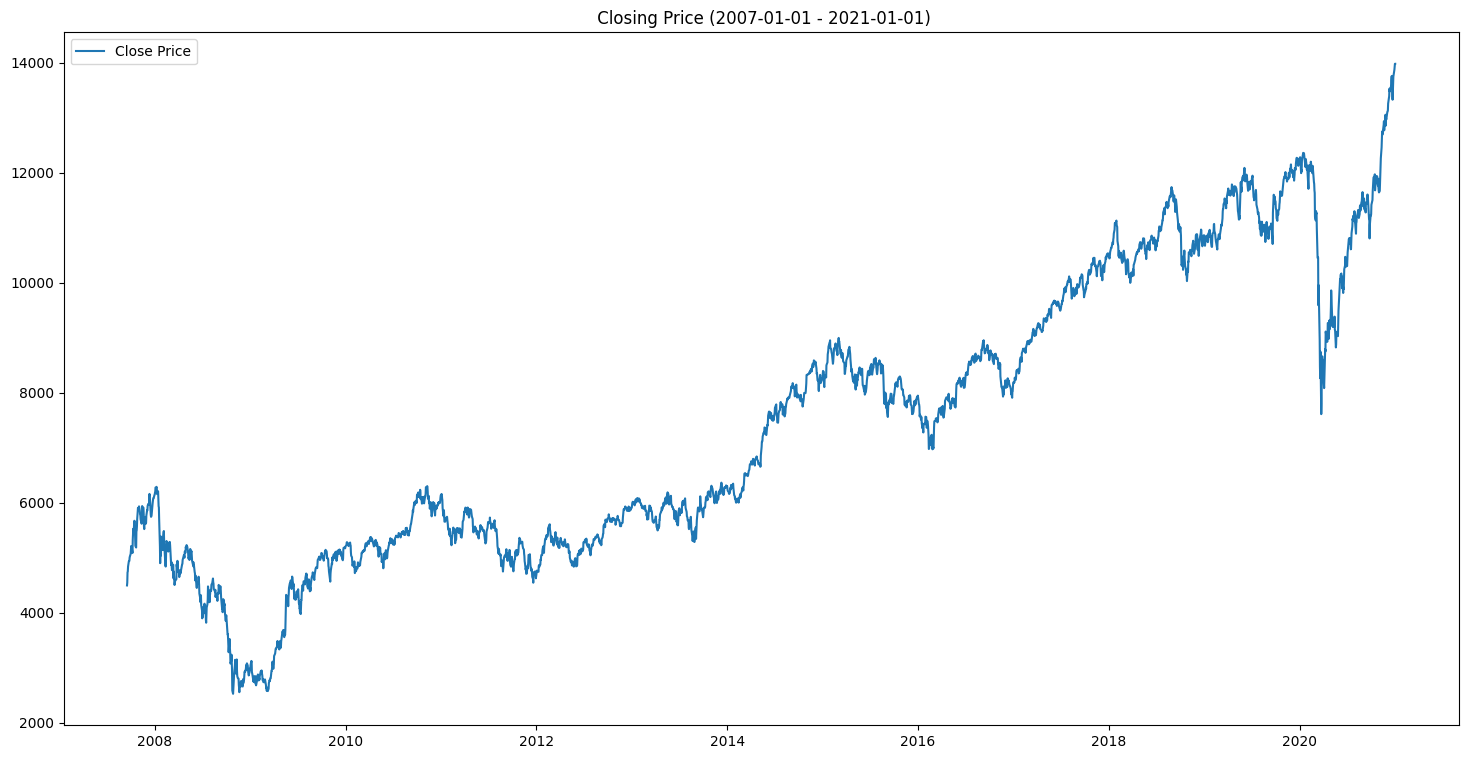

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(data["Close"], label="Close Price")
plt.title(f" Closing Price ({start} - {end})")
plt.legend()
plt.show()

# Defining RSI function

In [ ]:
def calculate_rsi(series, period=14): #period is 14 as 14 day rsi is being used
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    gain_rolling = gain.rolling(period).mean()
    loss_rolling = loss.rolling(period).mean()
    rs = gain_rolling / loss_rolling
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
#weekly close and weekly RSI since we are using weekly RSI here
weekly_close = data["Close"].resample("W-FRI").last().squeeze()  # squeeze ensures 1D, resample because rsi is evaluated on the basis of week end basis..so rsi of the week is rsi of fri
weekly_rsi = calculate_rsi(weekly_close, 14).squeeze()
#combining into DataFrame
weekly_data = pd.DataFrame({"Close": weekly_close,"RSI_weekly": weekly_rsi})

# Implementing the 50-50 strategy

##Weekly RSI chart

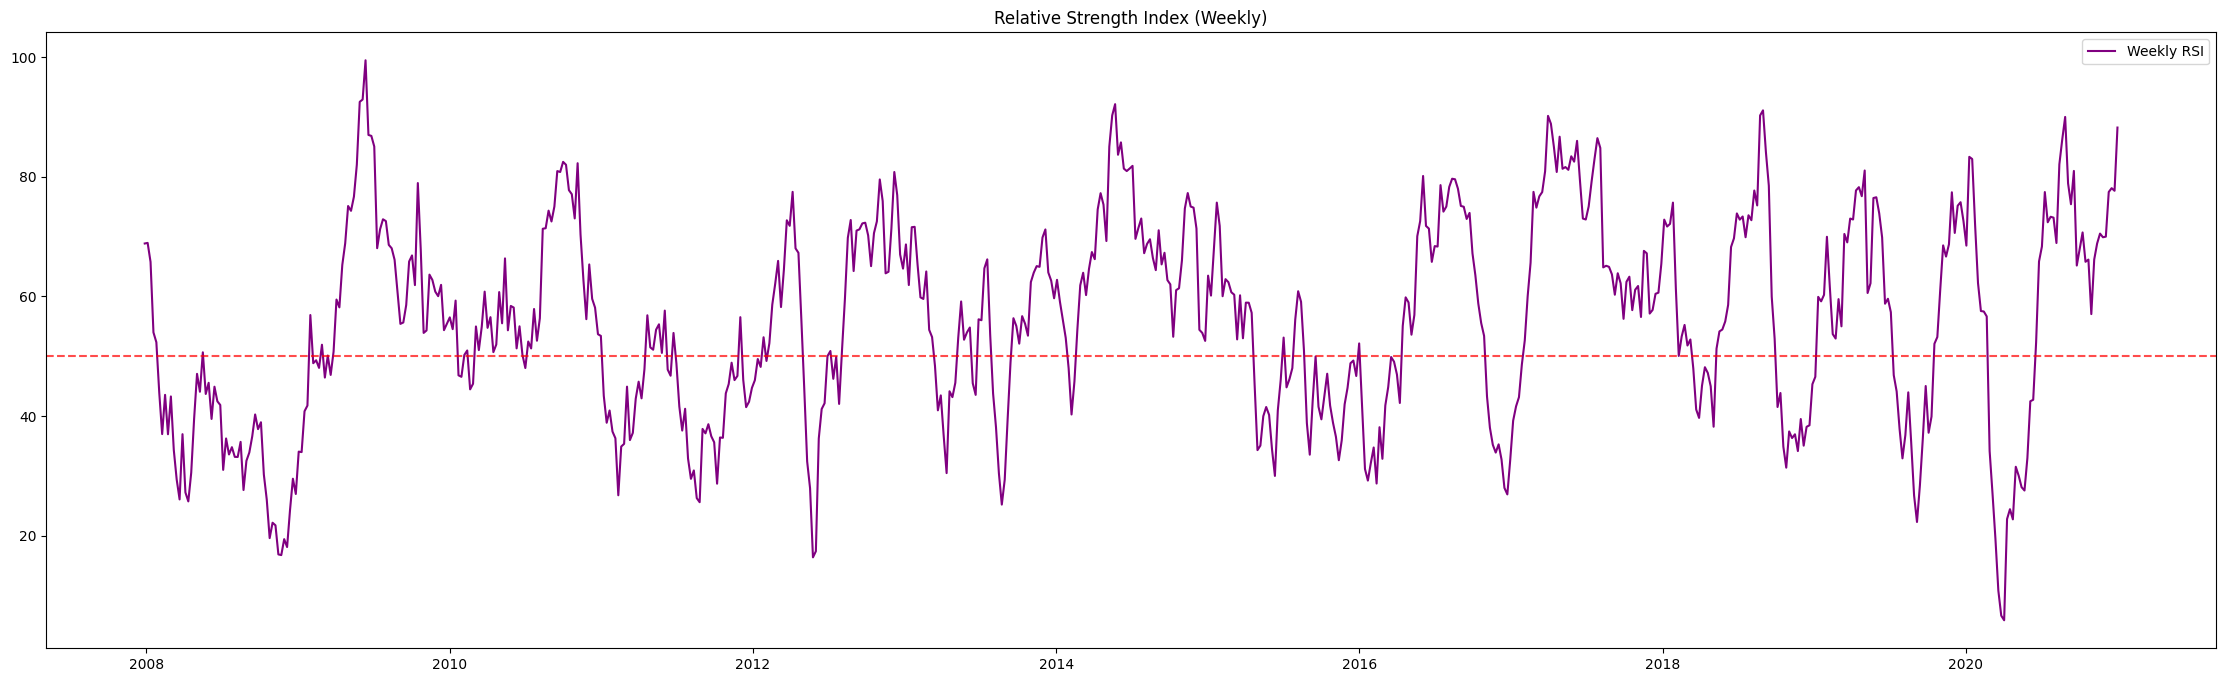

In [ ]:
plt.figure(figsize=(28,8))
plt.plot(weekly_data["RSI_weekly"], label="Weekly RSI", color="purple")
plt.axhline(50, linestyle="--", color="red", alpha=0.7)
plt.title("Relative Strength Index (Weekly)")
plt.legend()
plt.show()

##Trend Analysis for 50-50 strategy

In [ ]:
def trend_analysis_rsi(df, rsi_col="RSI_weekly", threshold=50):
    trends = []
    df = df.copy() #making a copy to avoid modifying original dataframe

    #defining signals -1 and 1
    df["Signal"] = 0
    df.loc[df[rsi_col] > threshold, "Signal"] = 1
    df.loc[df[rsi_col] < threshold, "Signal"] = -1

    #initializing for trend detection
    start_idx = 0
    current_signal = df["Signal"].iloc[0]

    #looping through each row to detect changes
    for i in range(1, len(df)):
        signal = df["Signal"].iloc[i]
        #when the signal changes (excluding neutral 0), record the previous trend
        if signal != current_signal and signal != 0:
            start_date = df.index[start_idx]
            end_date = df.index[i-1]
            start_price = df["Close"].iloc[start_idx]
            end_price = df["Close"].iloc[i-1]
            total_days = (end_date - start_date).days
            trend_type = "UP" if current_signal == 1 else "DOWN"
            ret = ((end_price - start_price) / start_price) * 100 #percentage return in a trend

            trends.append([start_date.date(), end_date.date(), total_days,trend_type, round(start_price,2), round(end_price,2),f"{ret:.2f}%"]) #appending trend info to list

            start_idx = i
            current_signal = signal

    #last trend
    start_date = df.index[start_idx]
    end_date = df.index[-1]
    start_price = df["Close"].iloc[start_idx]
    end_price = df["Close"].iloc[-1]
    total_days = (end_date - start_date).days
    trend_type = "UP" if current_signal == 1 else "DOWN"
    ret = ((end_price - start_price) / start_price) * 100
    trends.append([start_date.date(), end_date.date(), total_days,trend_type, round(start_price,2), round(end_price,2),f"{ret:.2f}%"])

    #list of trends to dataframe
    trend_df = pd.DataFrame(trends, columns=["Trend From", "Trend To", "Total Days of Trend","Trend Type", "Trend From Closing Price","Trend To Closing Price", "Return (%)"])
    return trend_df

#generating weekly trend table
trend_table_weekly = trend_analysis_rsi(weekly_data)
trend_table_weekly

,Trend From,Trend To,Total Days of Trend,Trend Type,Trend From Closing Price,Trend To Closing Price,Return (%)
0,2007-09-21,2007-12-21,91,DOWN,4837.55,5766.50,19.20%
1,2007-12-28,2008-01-25,28,UP,6079.70,5383.35,-11.45%
2,2008-02-01,2008-05-09,98,DOWN,5317.25,4982.60,-6.29%
3,2008-05-16,2008-05-16,0,UP,5157.70,5157.70,0.00%
4,2008-05-23,2009-01-23,245,DOWN,4946.55,2678.55,-45.85%
5,2009-01-30,2009-01-30,0,UP,2874.80,2874.80,0.00%
6,2009-02-06,2009-02-20,14,DOWN,2843.10,2736.45,-3.75%
7,2009-02-27,2009-02-27,0,UP,2763.65,2763.65,0.00%
8,2009-03-06,2009-03-06,0,DOWN,2620.15,2620.15,0.00%
9,2009-03-13,2009-03-13,0,UP,2719.25,2719.25,0.00%


## Yearly returns for 50-50 strategy

In [ ]:
def yearly_returns_strategy(trend_df, start_year=None, end_year=None):
    trend_df = trend_df.copy()
    trend_df["Trend From"] = pd.to_datetime(trend_df["Trend From"])
    trend_df["Trend To"] = pd.to_datetime(trend_df["Trend To"])

    #filter trends based on timestamps:
    if start_year:
        trend_df = trend_df[trend_df["Trend To"].dt.year >= start_year]
    if end_year:
        trend_df = trend_df[trend_df["Trend From"].dt.year <= end_year]

    yearly_ret = {} #empty dic for yearly returns
    for _, row in trend_df.iterrows():
        start_date = row["Trend From"]
        end_date = row["Trend To"]
        ret_pct = float(row["Return (%)"].strip('%')) / 100

        total_days = (end_date - start_date).days
        if total_days == 0:
            continue
        daily_ret = (1 + ret_pct) ** (1/total_days) - 1

        current_date = start_date
        while current_date <= end_date:
            year = current_date.year
            if start_year and year < start_year:
                current_date = pd.Timestamp(year=year+1, month=1, day=1)
                continue
            if end_year and year > end_year:
                break

            #days in this year for the trend
            if year == start_date.year and year == end_date.year:
                days_in_year = (end_date - start_date).days + 1
            elif year == start_date.year:
                days_in_year = (pd.Timestamp(year=year+1, month=1, day=1) - start_date).days
            elif year == end_date.year:
                days_in_year = (end_date - pd.Timestamp(year=year, month=1, day=1)).days + 1
            else:
                days_in_year = 365

            #compound daily returns for this year
            year_ret = (1 + daily_ret) ** days_in_year - 1
            if year in yearly_ret:
                yearly_ret[year] = (1 + yearly_ret[year]) * (1 + year_ret) - 1
            else:
                yearly_ret[year] = year_ret

            current_date = pd.Timestamp(year=year+1, month=1, day=1)

    #convert to DataFrame
    yearly_ret_df = pd.DataFrame({"Year": sorted(yearly_ret.keys()), "Yearly Return (%)": [round(v*100, 2) for v in [yearly_ret[y] for y in sorted(yearly_ret.keys())]]})

    return yearly_ret_df

# 50-50 strategy
yearly_50_50 = yearly_returns_strategy(trend_table_weekly, start_year=2007, end_year=2020)
print("50-50 Strategy Yearly Returns:")
print(yearly_50_50)

50-50 Strategy Yearly Returns:
    Year  Yearly Return (%)
0   2007              17.37
1   2008             -51.93
2   2009              49.32
3   2010              23.06
4   2011             -23.21
5   2012               6.77
6   2013               6.20
7   2014              28.55
8   2015               7.05
9   2016              11.26
10  2017              14.85
11  2018              12.47
12  2019               9.56
13  2020              23.15


# Implementing 60-40 strategy

##Weekly RSI chart

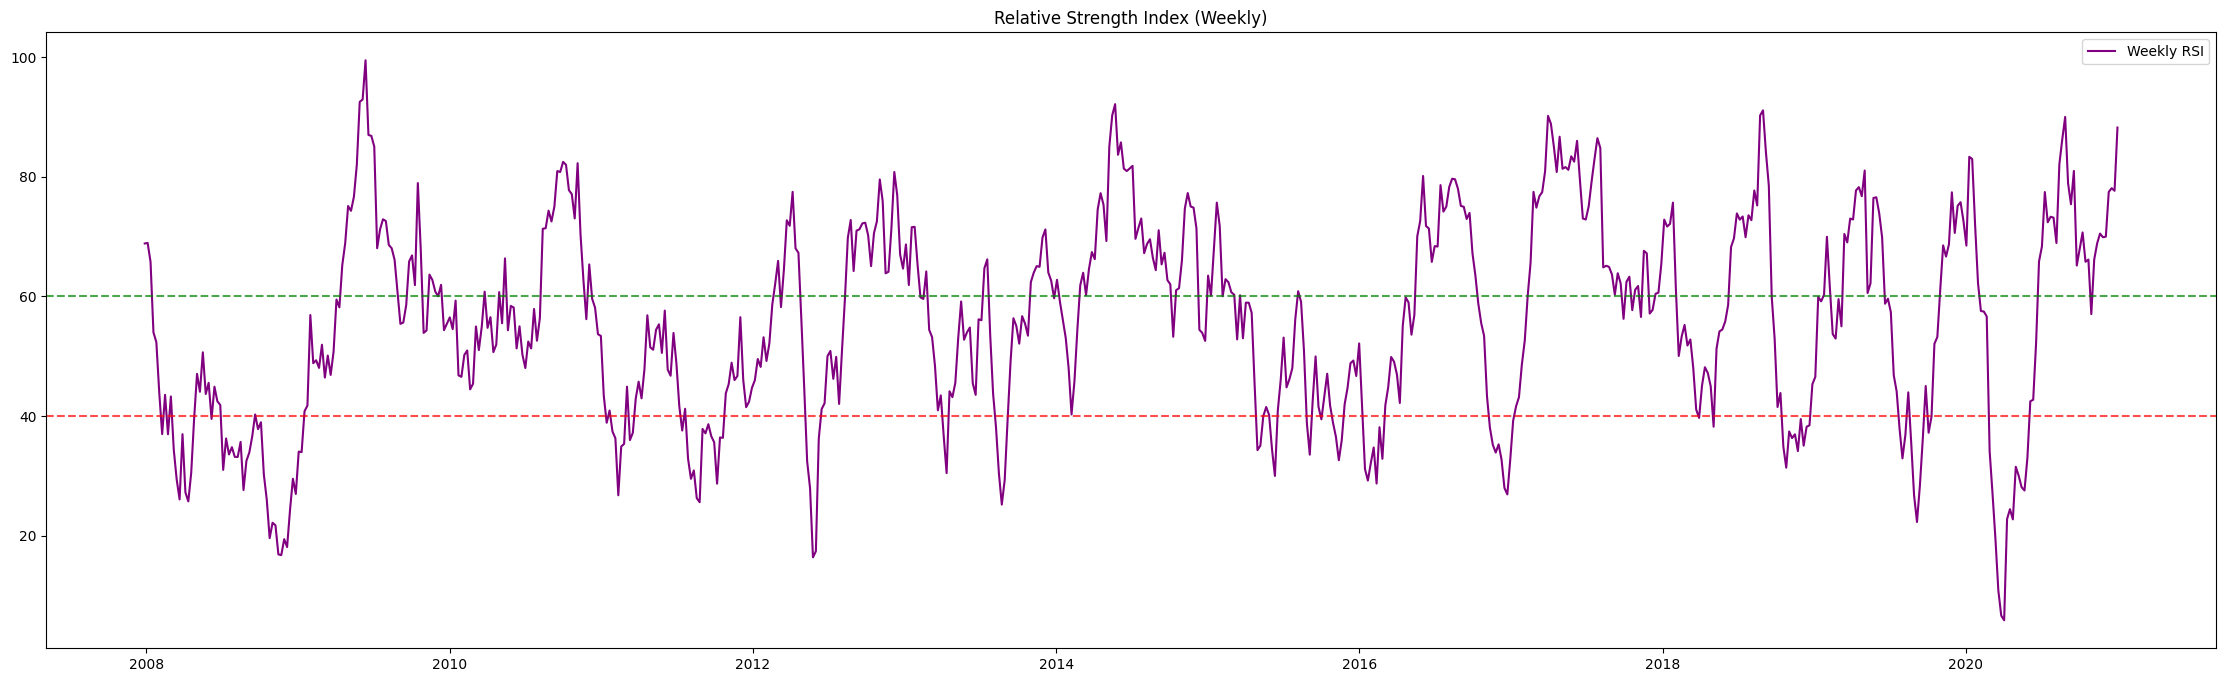

In [ ]:
plt.figure(figsize=(28,8))
plt.plot(weekly_data["RSI_weekly"], label="Weekly RSI", color="purple")
plt.axhline(60, linestyle="--", color="green", alpha=0.7)
plt.axhline(40, linestyle="--", color="red", alpha=0.7)
plt.title("Relative Strength Index (Weekly)")
plt.legend()
plt.show()

##Trend analysis for 60-40 strategy

In [ ]:
def trend_analysis_rsi_60_40(df, rsi_col="RSI_weekly", upper=60, lower=40):
    trends = []
    df = df.copy()  #copy to avoid modifying original dataframe

    #defining signals
    df["Signal"] = 0
    df.loc[df[rsi_col] > upper, "Signal"] = 1   # UP trend
    df.loc[df[rsi_col] < lower, "Signal"] = -1  # DOWN trend

    #initializing for trend detection
    start_idx = 0
    current_signal = df["Signal"].iloc[0]

    #looping through each row to detect trend changes
    for i in range(1, len(df)):
        signal = df["Signal"].iloc[i]
        if signal != current_signal and signal != 0:
            start_date = df.index[start_idx]
            end_date = df.index[i-1]
            start_price = df["Close"].iloc[start_idx]
            end_price = df["Close"].iloc[i-1]
            total_days = (end_date - start_date).days
            trend_type = "UP" if current_signal == 1 else "DOWN"
            ret = ((end_price - start_price) / start_price) * 100

            trends.append([start_date.date(), end_date.date(), total_days, trend_type, round(start_price,2), round(end_price,2), f"{ret:.2f}%"])

            start_idx = i
            current_signal = signal

    # last trend
    start_date = df.index[start_idx]
    end_date = df.index[-1]
    start_price = df["Close"].iloc[start_idx]
    end_price = df["Close"].iloc[-1]
    total_days = (end_date - start_date).days
    trend_type = "UP" if current_signal == 1 else "DOWN"
    ret = ((end_price - start_price) / start_price) * 100

    trends.append([start_date.date(), end_date.date(), total_days, trend_type, round(start_price,2), round(end_price,2), f"{ret:.2f}%"])

    # convert list to DataFrame
    trend_df = pd.DataFrame(trends, columns=["Trend From", "Trend To", "Total Days of Trend", "Trend Type", "Trend From Closing Price", "Trend To Closing Price", "Return (%)"])
    return trend_df

# generating weekly trend table for 60-40
trend_table_60_40 = trend_analysis_rsi_60_40(weekly_data)
trend_table_60_40

,Trend From,Trend To,Total Days of Trend,Trend Type,Trend From Closing Price,Trend To Closing Price,Return (%)
0,2007-09-21,2007-12-21,91,DOWN,4837.55,5766.50,19.20%
1,2007-12-28,2008-02-01,35,UP,6079.70,5317.25,-12.54%
2,2008-02-08,2009-04-10,427,DOWN,5120.35,3342.05,-34.73%
3,2009-04-17,2011-01-07,630,UP,3384.40,5904.60,74.47%
4,2011-01-14,2012-02-17,399,DOWN,5654.55,5564.30,-1.60%
5,2012-02-24,2012-05-04,70,UP,5429.30,5086.85,-6.31%
6,2012-05-11,2012-08-10,91,DOWN,4928.90,5320.40,7.94%
7,2012-08-17,2013-03-29,224,UP,5366.30,5682.55,5.89%
8,2013-04-05,2013-07-05,91,DOWN,5553.25,5867.90,5.67%
9,2013-07-12,2013-08-02,21,UP,6009.00,5677.90,-5.51%


##Yearly returns for 60-40 strategy

In [ ]:
#60-40 strategy
yearly_60_40 = yearly_returns_strategy(trend_table_60_40, start_year=2007, end_year=2020)
print("\n60-40 Strategy Yearly Returns:")
print(yearly_60_40)


60-40 Strategy Yearly Returns:
    Year  Yearly Return (%)
0   2007              17.62
1   2008             -36.25
2   2009              13.76
3   2010              38.05
4   2011              -0.80
5   2012               4.52
6   2013              16.22
7   2014              20.49
8   2015               5.71
9   2016              11.02
10  2017              13.19
11  2018              10.86
12  2019              10.99
13  2020              23.96


#For all trends in our dataframe

I've provided results for both all trends as well as 20 randomly sampled trends (as per the author)

## Data summary table

In [ ]:
from scipy import stats
#extracting actual returns
returns_50_50 = trend_table_weekly["Return (%)"].str.replace('%','').astype(float).tolist()
returns_60_40 = trend_table_60_40["Return (%)"].str.replace('%','').astype(float).tolist()

data_summary = pd.DataFrame({"Groups": ["Return of 50-50 Strategy", "Return of 60-40 Strategy"],"N": [len(returns_50_50), len(returns_60_40)],"Mean": [pd.Series(returns_50_50).mean(), pd.Series(returns_60_40).mean()],"Std. Dev": [pd.Series(returns_50_50).std(ddof=1), pd.Series(returns_60_40).std(ddof=1)],"Std. Error": [pd.Series(returns_50_50).sem(), pd.Series(returns_60_40).sem()]})
print("\nTable 1: Data Summary")
print(data_summary)


Table 1: Data Summary
                     Groups   N      Mean   Std. Dev  Std. Error
0  Return of 50-50 Strategy  58  2.459655  14.191126    1.863386
1  Return of 60-40 Strategy  26  6.413462  19.241939    3.773655


##ANOVA Source table

In [ ]:
#performing one-way ANOVA
f_stat, p_value = stats.f_oneway(returns_50_50, returns_60_40)

#degrees of Freedom
k = 2  # number of groups
N = len(returns_50_50) + len(returns_60_40)
df_between = k - 1
df_within = N - k
df_total = N - 1

#sum of Squares
grand_mean = pd.Series(returns_50_50 + returns_60_40).mean()
ss_between = len(returns_50_50)*(pd.Series(returns_50_50).mean() - grand_mean)**2 + \
             len(returns_60_40)*(pd.Series(returns_60_40).mean() - grand_mean)**2
ss_within = sum((pd.Series(returns_50_50) - pd.Series(returns_50_50).mean())**2) + \
            sum((pd.Series(returns_60_40) - pd.Series(returns_60_40).mean())**2)
ss_total = ss_between + ss_within

#mean Squares
ms_between = ss_between / df_between
ms_within = ss_within / df_within

table2 = pd.DataFrame({"Source": ["Between Groups", "Within Groups", "Total"],"Degrees of Freedom": [df_between, df_within, df_total],"Sum of Squares": [ss_between, ss_within, ss_total],"Mean Square": [ms_between, ms_within, ""],"F-Stat": [f_stat, "", ""],"P-Value": [p_value, "", ""]})
print("\nTable 2: ANOVA Source Table")
print(table2)


Table 2: ANOVA Source Table
           Source  Degrees of Freedom  Sum of Squares Mean Square    F-Stat  \
0  Between Groups                   1      280.642117  280.642117  1.109823   
1   Within Groups                  82    20735.423982  252.871024             
2           Total                  83    21016.066099                         

    P-Value  
0  0.295215  
1            
2            


##F & P value conclusion table for all trends

In [ ]:
table3 = pd.DataFrame({"F-statistic value": [f_stat],"P-value": [p_value]})
print("\nTable 3: F-Value & P-Value Conclusion")
print(table3)


Table 3: F-Value & P-Value Conclusion
   F-statistic value   P-value
0           1.109823  0.295215


# For 20 randomly sampled trends (as per author)

## Data summary table

In [ ]:
#when we take 20 trends as per the author did
from scipy import stats
trend_table_50_50_sample = trend_table_weekly.sample(n=20, random_state=42).reset_index(drop=True)
trend_table_60_40_sample = trend_table_60_40.sample(n=20, random_state=42).reset_index(drop=True)

#extracting actual returns from sampled trend tables
returns_50_50 = trend_table_50_50_sample["Return (%)"].str.replace('%','').astype(float).tolist()
returns_60_40 = trend_table_60_40_sample["Return (%)"].str.replace('%','').astype(float).tolist()

#data summary table
data_summary = pd.DataFrame({"Groups": ["Return of 50-50 Strategy", "Return of 60-40 Strategy"],"N": [len(returns_50_50), len(returns_60_40)],"Mean": [pd.Series(returns_50_50).mean(), pd.Series(returns_60_40).mean()],"Std. Dev": [pd.Series(returns_50_50).std(ddof=1), pd.Series(returns_60_40).std(ddof=1)],"Std. Error": [pd.Series(returns_50_50).sem(), pd.Series(returns_60_40).sem()]})
print("\nTable 1: Data Summary (Sampled 20 Trends)")
print(data_summary)


Table 1: Data Summary (Sampled 20 Trends)
                     Groups   N   Mean   Std. Dev  Std. Error
0  Return of 50-50 Strategy  20  0.006  12.579189    2.812792
1  Return of 60-40 Strategy  20  7.109  21.835385    4.882541


##ANOVA Source table

In [ ]:
#anova source table
#performing one-way ANOVA
f_stat, p_value = stats.f_oneway(returns_50_50, returns_60_40)

#degrees of Freedom
k = 2  #number of groups
N = len(returns_50_50) + len(returns_60_40)
df_between = k - 1
df_within = N - k
df_total = N - 1

#sum of Squares
grand_mean = pd.Series(returns_50_50 + returns_60_40).mean()
ss_between = len(returns_50_50)*(pd.Series(returns_50_50).mean() - grand_mean)**2 + \
             len(returns_60_40)*(pd.Series(returns_60_40).mean() - grand_mean)**2
ss_within = sum((pd.Series(returns_50_50) - pd.Series(returns_50_50).mean())**2) + \
            sum((pd.Series(returns_60_40) - pd.Series(returns_60_40).mean())**2)
ss_total = ss_between + ss_within

#mean Squares
ms_between = ss_between / df_between
ms_within = ss_within / df_within

table2 = pd.DataFrame({"Source": ["Between Groups", "Within Groups", "Total"],"Degrees of Freedom": [df_between, df_within, df_total],"Sum of Squares": [ss_between, ss_within, ss_total],"Mean Square": [ms_between, ms_within, ""],"F-Stat": [f_stat, "", ""],"P-Value": [p_value, "", ""]})
print("\nTable 2: ANOVA Source Table (Sampled 20 Trends)")
print(table2)


Table 2: ANOVA Source Table (Sampled 20 Trends)
           Source  Degrees of Freedom  Sum of Squares Mean Square    F-Stat  \
0  Between Groups                   1       504.52609   504.52609  1.589008   
1   Within Groups                  38     12065.38086  317.510023             
2           Total                  39     12569.90695                         

    P-Value  
0  0.215153  
1            
2            


##F & P value conclusion table for 20 random trends

In [ ]:
table3 = pd.DataFrame({"F-statistic value": [f_stat],"P-value": [p_value]})
print("\nTable 3: F-Value & P-Value Conclusion (Sampled 20 Trends)")
print(table3)


Table 3: F-Value & P-Value Conclusion (Sampled 20 Trends)
   F-statistic value   P-value
0           1.589008  0.215153


# Brownie Points

## Using high quality database

It wasn't possible for me to use a high-quality database in this paper (i've used it in paper 2) as none of them supported NIFTY50 index, or the one who supported were paid. I tried AlphaVantage, Tiingo, Quandl..but none of them worked. I also tried using NSE historical datas but they wouldn't let me download all 20 years of it at once.

##Advanced Implementation

I've used the more widely accepted 70-30 indicator here.

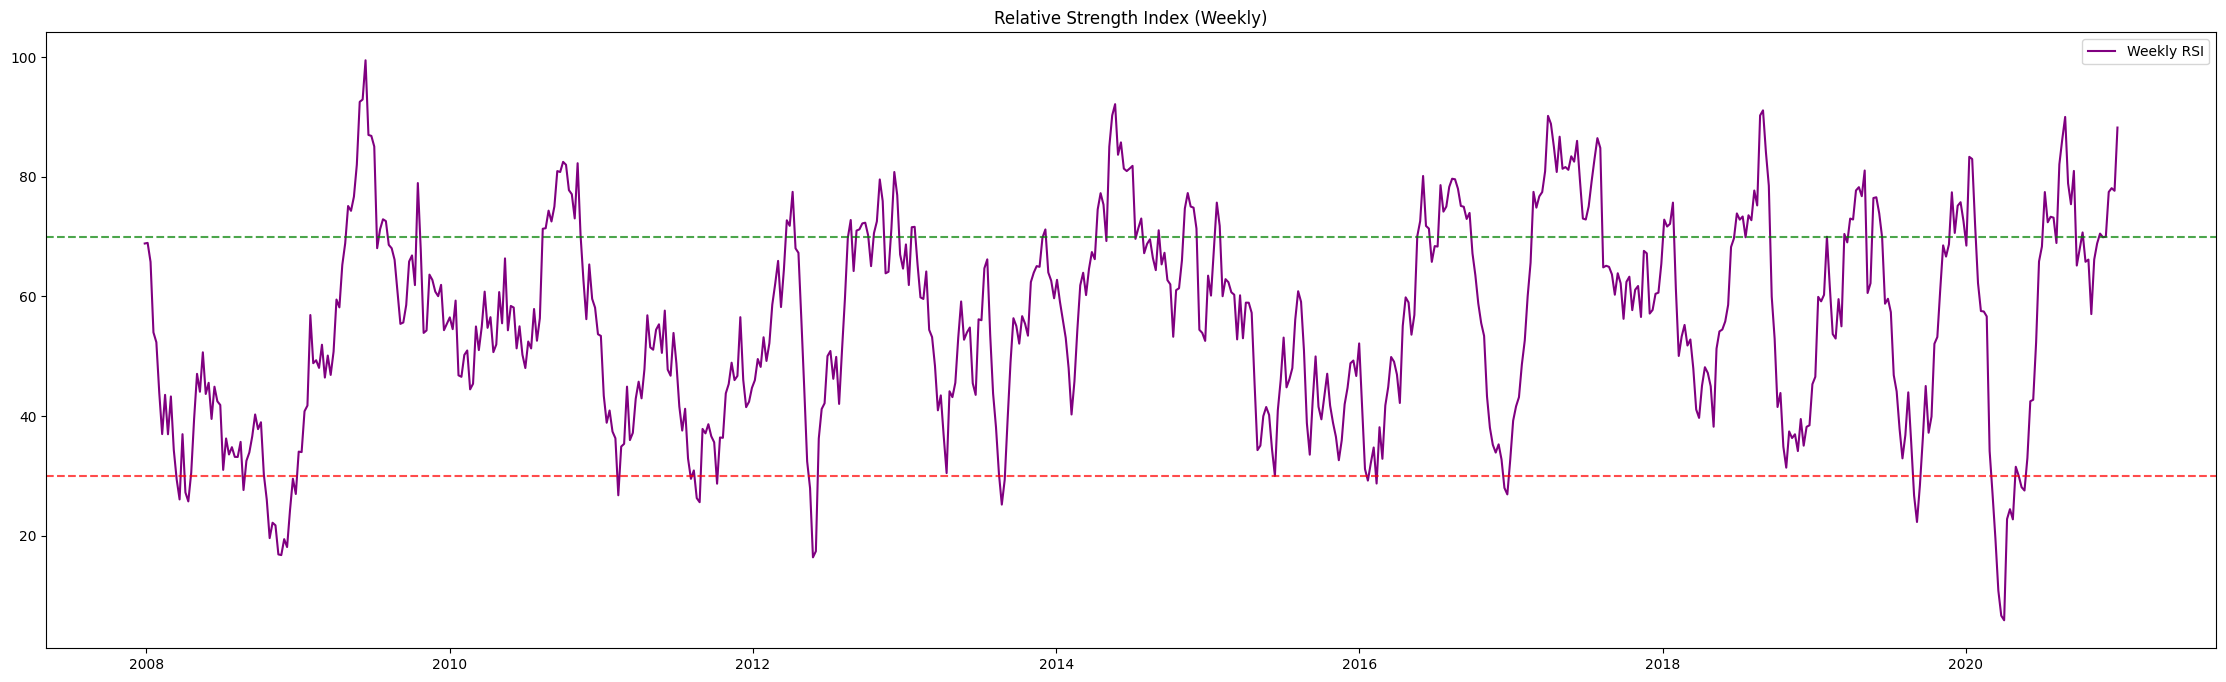

In [ ]:
plt.figure(figsize=(28,8))
plt.plot(weekly_data["RSI_weekly"], label="Weekly RSI", color="purple")
plt.axhline(70, linestyle="--", color="green", alpha=0.7)
plt.axhline(30, linestyle="--", color="red", alpha=0.7)
plt.title("Relative Strength Index (Weekly)")
plt.legend()
plt.show()

In [ ]:
def trend_analysis_rsi_70_30(df, rsi_col="RSI_weekly", upper=70, lower=30):
    trends = []
    df = df.copy()  #copy to avoid modifying original dataframe

    #defining signals
    df["Signal"] = 0
    df.loc[df[rsi_col] > upper, "Signal"] = 1   # UP trend
    df.loc[df[rsi_col] < lower, "Signal"] = -1  # DOWN trend

    #initializing for trend detection
    start_idx = 0
    current_signal = df["Signal"].iloc[0]

    #looping through each row to detect trend changes
    for i in range(1, len(df)):
        signal = df["Signal"].iloc[i]
        if signal != current_signal and signal != 0:
            start_date = df.index[start_idx]
            end_date = df.index[i-1]
            start_price = df["Close"].iloc[start_idx]
            end_price = df["Close"].iloc[i-1]
            total_days = (end_date - start_date).days
            trend_type = "UP" if current_signal == 1 else "DOWN"
            ret = ((end_price - start_price) / start_price) * 100

            trends.append([start_date.date(), end_date.date(), total_days, trend_type, round(start_price,2), round(end_price,2), f"{ret:.2f}%"])

            start_idx = i
            current_signal = signal

    #last trend
    start_date = df.index[start_idx]
    end_date = df.index[-1]
    start_price = df["Close"].iloc[start_idx]
    end_price = df["Close"].iloc[-1]
    total_days = (end_date - start_date).days
    trend_type = "UP" if current_signal == 1 else "DOWN"
    ret = ((end_price - start_price) / start_price) * 100

    trends.append([start_date.date(), end_date.date(), total_days, trend_type, round(start_price,2), round(end_price,2), f"{ret:.2f}%"])

    #convert list to DataFrame
    trend_df = pd.DataFrame(trends, columns=["Trend From", "Trend To", "Total Days of Trend", "Trend Type", "Trend From Closing Price", "Trend To Closing Price", "Return (%)"])
    return trend_df

#generating weekly trend table for 70-30
trend_table_70_30 = trend_analysis_rsi_70_30(weekly_data)
trend_table_70_30

,Trend From,Trend To,Total Days of Trend,Trend Type,Trend From Closing Price,Trend To Closing Price,Return (%)
0,2007-09-21,2008-03-07,168,DOWN,4837.55,4771.60,-1.36%
1,2008-03-14,2009-04-24,406,DOWN,4745.80,3480.75,-26.66%
2,2009-05-01,2011-02-04,644,UP,3473.95,5395.75,55.32%
3,2011-02-11,2012-03-16,399,DOWN,5310.00,5317.90,0.15%
4,2012-03-23,2012-05-11,49,UP,5278.20,4928.90,-6.62%
5,2012-05-18,2012-08-17,91,DOWN,4891.45,5366.30,9.71%
6,2012-08-24,2013-08-16,357,UP,5386.70,5507.85,2.25%
7,2013-08-23,2013-11-29,98,DOWN,5471.75,6176.10,12.87%
8,2013-12-06,2016-01-15,770,UP,6259.90,7437.80,18.82%
9,2016-01-22,2016-05-13,112,DOWN,7422.45,7814.90,5.29%


In [ ]:
#70-30 strategy
yearly_70_30 = yearly_returns_strategy(trend_table_70_30, start_year=2007, end_year=2020)
print("70-30 Strategy Yearly Returns:")
print(yearly_70_30)

70-30 Strategy Yearly Returns:
    Year  Yearly Return (%)
0   2007              -0.83
1   2008             -20.49
2   2009               8.38
3   2010              28.35
4   2011               2.55
5   2012               3.27
6   2013              15.30
7   2014               8.52
8   2015               8.52
9   2016              15.04
10  2017              13.53
11  2018               8.00
12  2019              10.68
13  2020              19.45
